In [22]:
import bilby
import gwmemory
from waveforms import osc_freq_XPHM, mem_freq_XPHM, mem_freq_XPHM_only
import numpy as np
import lalsimulation as lalsim
import matplotlib.pyplot as plt
from gwmemory.utils import combine_modes

In [23]:
mass_1=33
mass_2=30
a_1=0.5
a_2=0.4
luminosity_distance=400
theta_jn=np.pi/3
psi=1                   # guess
phase=5                   # guess
geocent_time=1126259642.413
ra=3           
dec=-1.2108
tilt_1 = 1
tilt_2 = 1
time_jitter=0
phi_12=0.2
phi_jl=0.2

reference_frequency = 20.0

mpc = 3e22
SOLAR_MASS = 1.988409870698051e30

distance = 400*mpc
m1 = mass_1*SOLAR_MASS
m2 = mass_2*SOLAR_MASS

iota, spin_1x, spin_1y, spin_1z, spin_2x, spin_2y, spin_2z = bilby.gw.conversion.bilby_to_lalsimulation_spins(
        theta_jn=theta_jn, phi_jl=phi_jl, tilt_1=tilt_1, tilt_2=tilt_2,
        phi_12=phi_12, a_1=a_1, a_2=a_2, mass_1=mass_1*SOLAR_MASS, mass_2=mass_2*SOLAR_MASS,
        reference_frequency=reference_frequency, phase=phase)
print('iota', iota)
print('theta_jn', theta_jn)
params = dict(f_min = 20.0,
              f_ref = 20.0,
              phiRef=phase,     
              approximant = lalsim.GetApproximantFromString('IMRPhenomXPHM'),
              LALpars=None,
              m1=m1,
              m2=m2,
              S1x=spin_1x,
              S1y=spin_1y,
              S1z=spin_1z,
              S2x=spin_2x,
              S2y=spin_2y,
              S2z=spin_2z,
              distance= distance,
              inclination=iota,
              deltaF = 1/4,
              f_max = 1024,
              )

waveform_modes = lalsim.SimInspiralChooseFDModes(**params)

h_lm = dict()
while waveform_modes is not None:
    mode = (waveform_modes.l, waveform_modes.m)
    data = waveform_modes.mode.data.data[:-1]
    h_lm[mode] = np.roll(data, 4 * params['f_max'])
    #h_lm[mode] = data
    waveform_modes = waveform_modes.next

iota 1.0223292794023269
theta_jn 1.0471975511965976


In [24]:
import lal

def combine_modes_moritz(h_lm, inc, phase):
    """Calculate the plus and cross polarisations of the waveform from the spherical harmonic decomposition."""
    # total = sum([h_lm[(l, m)] * harmonics.sYlm(-2, l, m, inc, phase) for l, m in h_lm])
    total = sum([h_lm[(l, m)] * lal.SpinWeightedSphericalHarmonic(inc,0, -2, l, m) for l, m in h_lm])
    h_plus_cross = dict(plus=total.real, cross=-total.imag)
    return h_plus_cross

theta_jn ver2 1.0470886587206898
{(4, 4): array([6.31314186e-24+6.86209772e-25j, 6.34763600e-24+2.04396046e-25j,
       6.34526670e-24-2.78710952e-25j, ...,
       5.99170176e-24+2.09586895e-24j, 6.13463857e-24+1.63471700e-24j,
       6.24199979e-24+1.16391305e-24j]), (4, 3): array([5.44293462e-25-1.03036635e-24j, 4.62928796e-25-1.06784310e-24j,
       3.78999909e-25-1.09893204e-24j, ...,
       7.68248615e-25-8.81909595e-25j, 6.97409898e-25-9.37133488e-25j,
       6.22609654e-25-9.86713573e-25j]), (4, 2): array([-1.41839450e-25-6.31739879e-26j, -1.46395867e-25-5.22465831e-26j,
       -1.50111914e-25-4.09937994e-26j, ...,
       -1.23428702e-25-9.33904307e-26j, -1.30321255e-25-8.38048568e-26j,
       -1.36470453e-25-7.37134526e-26j]), (4, 1): array([-6.00940549e-27+1.65777561e-26j, -4.76234148e-27+1.69832492e-26j,
       -3.48926551e-27+1.72963332e-26j, ...,
       -9.52737238e-27+1.48316424e-26j, -8.39843092e-27+1.54989747e-26j,
       -7.22364926e-27+1.60820864e-26j]), (4, 0): array(

/home/shunyin.cheung/.conda/envs/altenv/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


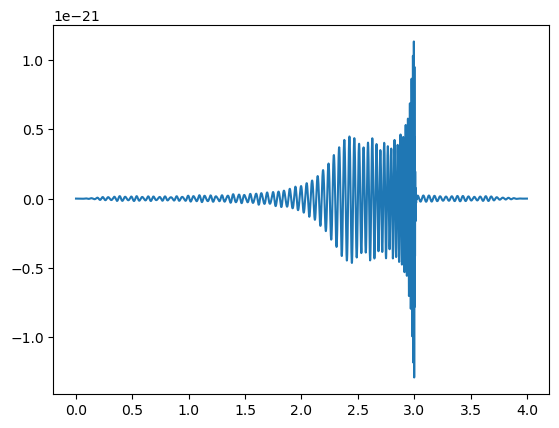

In [37]:
from scipy.signal.windows import tukey

params = dict(m1_SI = m1,
              m2_SI = m2,
              f_ref=20.0,
              phiRef = phase,
              incl = iota,
              s1x = spin_1x,
              s1y = spin_1y,
              s1z = spin_1z,
              s2x = spin_2x,
              s2y = spin_2y,
              s2z= spin_2z,
              lalParams = None)

chi1L, chi2L, chi_p, theta_jn2, alpha0, phi_aligned, zeta_polarisation \
      = lalsim.SimIMRPhenomXPCalculateModelParametersFromSourceFrame(**params)
print('theta_jn ver2',theta_jn2)
h_lm_td = {}
for l,m in h_lm:
    mode = (l, m)
    h_lm_td[mode] = np.roll(np.fft.ifft(h_lm[mode]), int(4-1)*2048)*2048
print(h_lm_td)
full_waveform = combine_modes(h_lm_td, inc=theta_jn, phase=0)   # phase must be zero

window = tukey(full_waveform['plus'].size, 0.2)

plt.figure()
plt.plot(np.linspace(0, 4, 8192), full_waveform['plus']*window-1j*full_waveform['cross']*window)
plt.show()

full_waveform_fd = {}
for key in full_waveform:
    full_waveform_fd[key]= np.fft.rfft(full_waveform[key]*window)/2048

In [38]:
params = dict(f_min = 20.0,
              f_ref = 20.0,
              approximant = lalsim.GetApproximantFromString('IMRPhenomXPHM'),
              LALpars=None,
              m1=mass_1*SOLAR_MASS,
              m2=mass_2*SOLAR_MASS,
              S1x=spin_1x,
              S1y=spin_1y,
              S1z=spin_1z,
              S2x=spin_2x,
              S2y=spin_2y,
              S2z=spin_2z,
              distance= 400*mpc,
              inclination=iota,
              deltaF = 1/4,
              f_max = 1024,
              phiRef = phase, 
              meanPerAno = 0.0,
              eccentricity = 0.0,
              longAscNodes = 0.0,
              )

hplus, hcross = lalsim.SimInspiralChooseFDWaveform(**params)

plusFD = hplus.data.data
crossFD = hcross.data.data

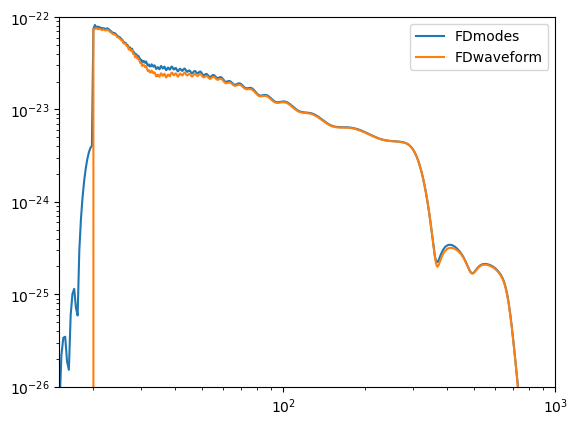

In [39]:
frequency = np.linspace(0, 1024, 4097)

plt.figure()
#plt.title('tilt_{1,2}=1')
plt.loglog(frequency, np.abs(full_waveform_fd['plus']+full_waveform_fd['cross']), label='FDmodes')
plt.loglog(frequency, np.abs(plusFD+crossFD), label='FDwaveform')
plt.xlim(15, 1000)
plt.ylim(1e-26, 1e-22)
plt.legend()
# plt.savefig('tests/compare_FDmodes_vs_FDwaveform_fd.png')

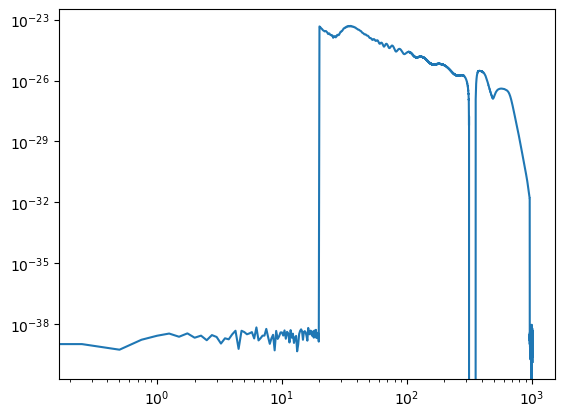

In [28]:
plt.figure()
plt.loglog(frequency, np.abs(full_waveform_fd['plus']+full_waveform_fd['cross'])-np.abs(plusFD+crossFD), label='difference')

/local/shunyin.cheung/ipykernel_4000856/126059141.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(frequency, np.abs(full_waveform_fd['plus']+full_waveform_fd['cross'])/np.abs(plusFD+crossFD), label='difference')
/local/shunyin.cheung/ipykernel_4000856/126059141.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(frequency, np.abs(full_waveform_fd['plus']+full_waveform_fd['cross'])/np.abs(plusFD+crossFD), label='difference')


(0.8, 1.2)

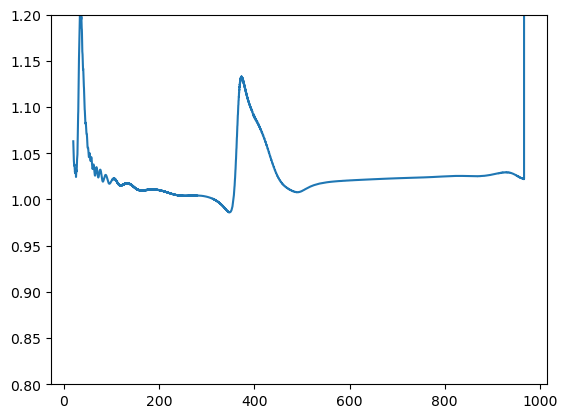

In [29]:
plt.figure()
plt.plot(frequency, np.abs(full_waveform_fd['plus']+full_waveform_fd['cross'])/np.abs(plusFD+crossFD), label='difference')
plt.ylim(0.8, 1.2)